# Семинар 04 – Линейные модели в задачах классификации

<a id="Content"></a>
# Содержание
0. [Постановка задачи](#0)
1. [Метрики классификации](#1)
   - [Точность ответов (precision)](#1.1)
   - [Полнота ответов (recall)](#1.2)
   - [Доля правильных ответов (accuracy)](#1.3)
   - [F-score](#1.4)
   - [ROC-AUC score](#1.5)
   - [Метрики многоклассовой классификации](#1.6)
2. [Линейный модели для задачи классификации](#2)
   - [Логистическая регрессия для задачи многоклассовой классификации](#2.1)
   - [Solvers](#2.2)
3. [Что почитать](#3)

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.stats as st
import warnings
warnings.simplefilter('ignore')

<a id="0"></a>
# 0. Постановка задачи

![picture](data/logreg.png)

Где линейная модель - это: $$ \hat{y} = f(x) = \theta_0*1 + \theta_1*x_1 + ... + \theta_n*x_n = \theta^T*X$$

Зачем нам нужна логистическая регрессия? 
$$ p_{\text{+}} = P(y = 1|X) \in [0, 1] $$
$$y_{\text{pred}} \in \mathbb{R}$$

Хотим рациональное значение, полученное из линейной регрессии перевести в вероятность принадлежности данному классу:

$$ \frac {p_{\text{+}}}{1 - p_{\text{+}}} \in [0, +\infty) $$
$$ log{\frac {p_{\text{+}}}{1 - p_{\text{+}}}} \in \mathbb{R} $$

Получаем:

$$
p_{\text{+}} = \frac {1}{1 + e^{-\theta^T*X}} = \sigma(\theta^T*X) \in [0, 1]
$$


<a id="1"></a>
# 1. Метрики классификации

In [2]:
from sklearn.datasets import fetch_olivetti_faces

In [3]:
data = fetch_olivetti_faces()
data.target

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13,
       13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15,
       15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 18,
       18, 18, 18, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 20, 20, 20, 20,
       20, 20, 20, 20, 20, 20, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 22,
       22, 22, 22, 22, 22

In [4]:
X, y = data.data, data.target

In [5]:
n_row, n_col = 2, 3
n_components = n_row * n_col
image_shape = (64, 64)
rng = 0

# #############################################################################
# Load faces data
faces, _ = fetch_olivetti_faces(return_X_y=True, shuffle=True,
                                random_state=rng)
n_samples, n_features = faces.shape

def plot_gallery(title, images, n_col=n_col, n_row=n_row, cmap=plt.cm.gray):
    plt.figure(figsize=(2. * n_col, 2.26 * n_row))
    plt.suptitle(title, size=16)
    for i, comp in enumerate(images):
        plt.subplot(n_row, n_col, i + 1)
        vmax = max(comp.max(), -comp.min())
        plt.imshow(comp.reshape(image_shape), cmap=cmap,
                   interpolation='nearest',
                   vmin=-vmax, vmax=vmax)
        plt.xticks(())
        plt.yticks(())
    plt.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)

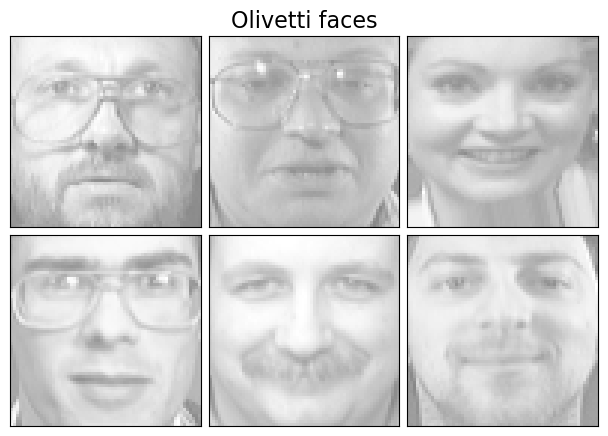

In [6]:
plot_gallery("Olivetti faces", faces[:n_components])

### Подготовим заведомо несбалансированную выборку (3 класса)

In [7]:
indx_0 = np.where(y == 0)[0]
indx_1 = np.where(y == 1)[0][:len(indx_0)]
print(indx_0)
print(indx_1)

[0 1 2 3 4 5 6 7 8 9]
[10 11 12 13 14 15 16 17 18 19]


In [8]:
indx_2 = np.where(y == 2)[0][:3]
indx_2

array([20, 21, 22])

In [22]:
X = X[np.concatenate((np.concatenate((indx_1, indx_0)), indx_2))]
y = y[np.concatenate((np.concatenate((indx_1, indx_0)), indx_2))]

In [10]:
print('В датасете {} объектов и {} признака'.format(X.shape[0], X.shape[1]))

В датасете 23 объектов и 4096 признака


### Разделим выборку на две части: обучающую и тестовую

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size=0.5,
                                                    test_size=0.5,
                                                    shuffle=True,
                                                   random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((11, 4096), (12, 4096), (11,), (12,))

In [13]:
from sklearn.neighbors import KNeighborsClassifier

Зададим классификатор:

In [14]:
knn = KNeighborsClassifier(n_neighbors=5)

In [15]:
knn.fit(X_train, y_train)
knn_predictons = knn.predict(X_test)

In [16]:
preds = pd.DataFrame(y_test, columns=['True'])
preds['knn_pred'] = knn_predictons

In [17]:
preds

,True,knn_pred
0,0,0
1,1,1
2,1,1
3,1,1
4,0,0
5,0,0
6,1,1
7,0,0
8,1,1
9,1,1


Что можно заметить?
На 0 и 1 класса классификатор отработал хорошо, но 2 класс он не видел и не смог его определить

![img](data/metrics_class.jpg)

<a id="1.1"></a>
## 1.1. Точность ответов (precision)

$$
\text{Precision} = \frac{TP}{TP + FP}$$

*Простыми словами*: какая доля предсказаний оказалась правильной

*Пример*: В задаче классификации писем на спам/не спам нам важнее не отправить важное письмо (label = -1) в мусорку, даже если пропустим спам (label = 1). То есть мы хотим уменьшать количество на FP (ошибки I рода), когда мы истинно негативный класс (не спам) относим к положительному (спам).ссов.

**Задание 0**: Реализовать поиск метрики precision для случая, когда класс 1 - это позитивный класс. Метрику посчитать без учета различных классов.

In [18]:
y_test, knn_predictons

(array([0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 2]),
 array([0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1]))

In [19]:
def precision(true, predictions):
    # Выбираем класс 1 как True
    TP = 0
    FP = 0
    
        #YOUR_CODE_HERE
    
    prec = TP/(TP+FP)
    return prec

precision(y_test, knn_predictons)

ZeroDivisionError: division by zero

Тоже самое средставми sklearn:

In [ ]:
from sklearn.metrics import precision_score
precision_score(y_test, knn_predictons, labels=[1], average='micro')

<a id="1.2"></a>
## 1.2. Полнота ответов (recall)

$$
\text{Recall} = \frac{TP}{TP + FN}$$

*Простыми словами*: какую долю из всех объектов положительного класса алгоритм нашёл правильно

*Пример*: В задаче классификации больной человек/здоровый нам важно не пропустить всех больных (label = 1), даже если определили здорового человека (label = -1) больным. То есть мы хотим уменьшать количество FN (ошибки II рода), когда мы истинно положительный класс (больной человек) отнесли к негативному (здоровый человек)

**Задание 1**: Реализовать поиск метрики recall для случая, когда класс 1 - это позитивный класс. Метрику посчитать без учета различных классов.

In [ ]:
def recall(true, predictions):
    TP = 0
    FN = 0

        #YOUR_CODE_HERE

    rec = TP/(TP+FN)
    return rec
recall(y_test, knn_predictons)

Тоже самое средставми sklearn:

In [ ]:
from sklearn.metrics import recall_score
recall_score(y_test, knn_predictons, labels=[1], average='micro')

<a id="1.3"></a>
## 1.3. Доля правильных ответов (accuracy)

$$
\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}$$

*Простыми словами*: просто считаем сколько предсказали правильно любый классов по отношению вообще ко всем предсказаниям

In [25]:
def accuracy(true, predictions):
    acc = predictions[true == predictions].shape[0] / true.shape[0] 
    return acc
accuracy(y_test, knn_predictons)

0.9166666666666666

Тоже самое средставми sklearn:

In [23]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, knn_predictons)

0.9166666666666666

<a id="1.4"></a>
## 1.4. F-score

*Простыми словами*: хотим агрегировать precision и recall

$$
F1 = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}$$

F1-мера - это частный случай F_beta-меры:

$$
F_\beta = (1 + \beta^2) \cdot \frac{\text{Precision} \cdot \text{Recall}}{\beta^2 \cdot \text{Precision} + \text{Recall}}$$

Если нам важнее precision:
$$
\beta \in(0,  1]$$

Если же нам важнее recall:
$$
\beta > 1
$$

*Пример*: если болезнь страшная, то мы хотим и precision учитывать, но recall всё ещё важнее\]\]\]

In [24]:
def F1_score(true, predictions):
    f1 = 2*(recall(true, predictions)*precision(true, predictions))/(recall(true, predictions)+precision(true, predictions))
    return f1
F1_score(y_test, knn_predictons)

NameError: name 'recall' is not defined

Тоже самое средставми sklearn:

In [26]:
from sklearn.metrics import f1_score
f1_score(y_test, knn_predictons, labels=[1], average='micro')

0.9230769230769231

<a id="1.5"></a>
## 1.5. ROC-AUC score

![img](data/roc_auc.png)

$$
\text{TPR} = \frac{TP}{TP + FN}$$

TPR - истинная положительная доля

$$
\text{FPR} = \frac{FP}{FP + TN}$$

FPR - ложная положительная доля

Для этого, в отличае от других метрик, нам понадобятся не предсказания модели, а вероятности принадлежности классам, которые модель выдает.

In [27]:
probs = knn.predict_proba(X_test)

Также необходибо бинаризовать метки классов для подсчета TPR и FPR

In [28]:
from sklearn.preprocessing import label_binarize
counts = np.unique(y, return_counts=True)
y_test_bin = label_binarize(y_test, classes=counts[0])

In [29]:
y_test_bin

array([[1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [1, 0, 0],
       [0, 0, 1]])

Считаем TPR и FPR для каждого класса

In [172]:
from sklearn.metrics import roc_curve, auc

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in counts[0]:
    fpr[i], tpr[i], threshold = roc_curve(y_test_bin[:, i], probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [173]:
roc_auc

{0: 1.0, 1: 1.0, 2: 0.9545454545454546}

In [171]:
fpr["micro"], tpr["micro"], threshold = roc_curve(y_test_bin.ravel(), probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
roc_auc["micro"]

roc_auc

{0: 1.0, 1: 1.0, 2: 0.9545454545454546, 'micro': 0.9791666666666667}

In [33]:
threshold, probs.ravel()

(array([inf, 1. , 0.8, 0.6, 0.4, 0.2, 0. ]),
 array([0.6, 0.4, 0. , 0.2, 0.8, 0. , 0.2, 0.8, 0. , 0. , 0.8, 0.2, 1. ,
        0. , 0. , 0.8, 0.2, 0. , 0.2, 0.8, 0. , 0.6, 0.4, 0. , 0. , 0.8,
        0.2, 0.2, 0.8, 0. , 0.4, 0.2, 0.4, 0. , 0.6, 0.4]))

In [34]:
def plot_roc_curve(index=8):
    plt.figure()
    lw = 2
    plt.plot(fpr[index], tpr[index], color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[index])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for class {}'.format(index))
    plt.legend(loc="lower right")
    plt.show()

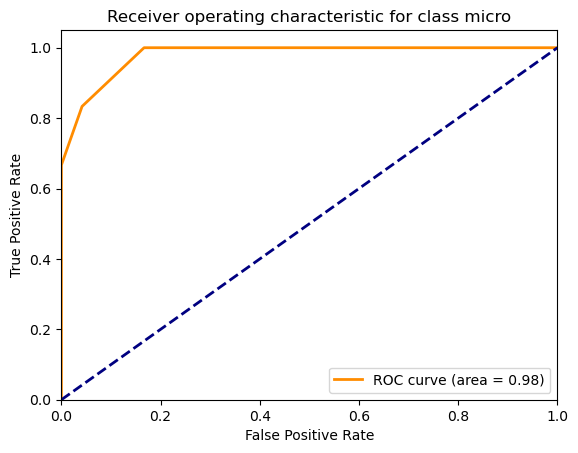

In [35]:
plot_roc_curve("micro")

<a id="1.6"></a>
## 1.6. Метрики многоклассовой классификации

1. **Микроусредненные метрики**:
Микроусреднение агрегирует информацию о всех классах, подсчитывая суммарные истинные положительные, ложные положительные и ложные отрицательные значения. Формулы для микроусредненных precision, recale выглядят так

$$
\text{Precision}_{\text{micro}} = \frac{\sum_{i} TP_i}{\sum_{i} (TP_i + FP_i)}
$$

$$
\text{Recall}_{\text{micro}} = \frac{\sum_{i} TP_i}{\sum_{i} (TP_i + FN_i)}
$$

*Зачем*: позволяет учитывать дисбаланс классов. Рассматривает все объекты из всех классов как одну большую совокупность. Оно взвешивает метрики по количеству примеров в каждом классе

2. **Макроусредненные метрики**:
Макроусреднение вычисляет метрики для каждого класса, а затем усредняет эти метрики. Формулы для макроусредненных precision, recore выглядят ть
$$
\text{Prescision}_{\text{macro}} = \frac{1}{K} \sum_{i} \frac{TP_i}{TP_i + FP_i}
$$

$$
\text{Recall}_{\text{macro}} = \frac{1}{K} \sum_{i} \frac{TP_i}{TP_i + FN_i}
$$

*Зачем*: все классы имеют одинаковый вес, независимо от их размера


<a id="2"></a>
# 2. Линейные модели для задачи классификации
В качестве демонстрации будем использовальзовать датасет с изображениями цифр

In [36]:
# Загрузим данные
from sklearn.datasets import load_digits
digits = load_digits()

In [37]:
X = digits.data
y = digits.target

In [38]:
# Посмотрим на кол-во объектов
X.shape, y.shape

((1797, 64), (1797,))

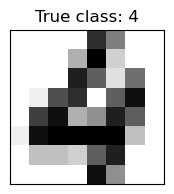

In [39]:
# Давайте, посмотрим, как вылядит случайный объект нашей выборки
target_image_id = np.random.randint(X.shape[0])

plt.figure(figsize=(4,2))
plt.imshow(X[target_image_id].reshape((8, 8)), cmap='binary')
plt.xticks([])
plt.yticks([])
plt.title('True class: '+ str(y[target_image_id]))
plt.show()

In [40]:
# Посмотрим на баланс классов
class_counts = np.unique(y, return_counts=True)

pd.DataFrame(class_counts[1], index=class_counts[0], columns=['Counts'])

,Counts
0,178
1,182
2,177
3,183
4,181
5,182
6,181
7,179
8,174
9,180


<a id="2.1"></a>
## 2.1. Логистическая регрессия для многоклассовой классификации

In [ ]:
# Загрузим нужные библиотеки
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

In [42]:
# Разделим выборку на тренировочную и тестовую
x_train, x_test, y_train, y_test = train_test_split(X, y,
                 train_size=0.8, test_size=0.2, shuffle=True,
                 random_state=42)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((1437, 64), (360, 64), (1437,), (360,))

*Логистическая регрессия позволяет решать задачу многоклассовой классификации. Класс ``LogisticRegression`` позвляет это делать двумя способами:*
- Стандартный One vs Rest (т.е. каждый класс отделяется от всех других). Параметр `multi_class='ovr'`.*
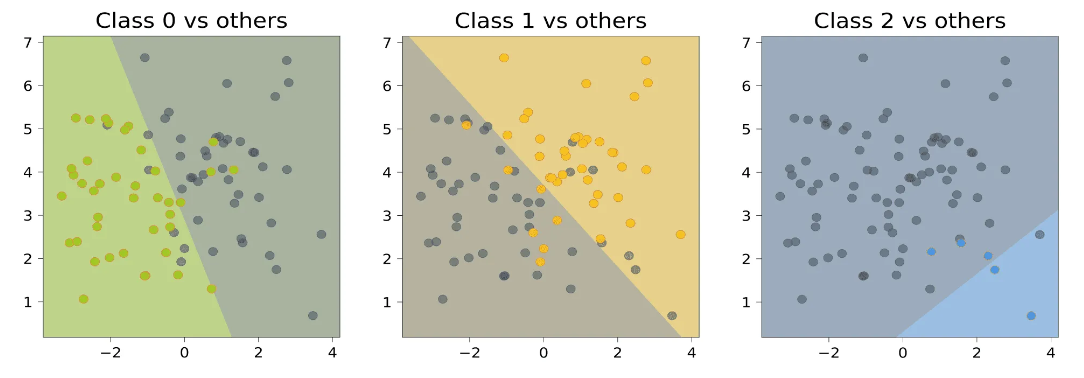
- One vs One: Используя кросс-энтропию (оценивается сразу вектор вероятностей принадлежности классам). Параметр `multi_class='multinomial'`.*
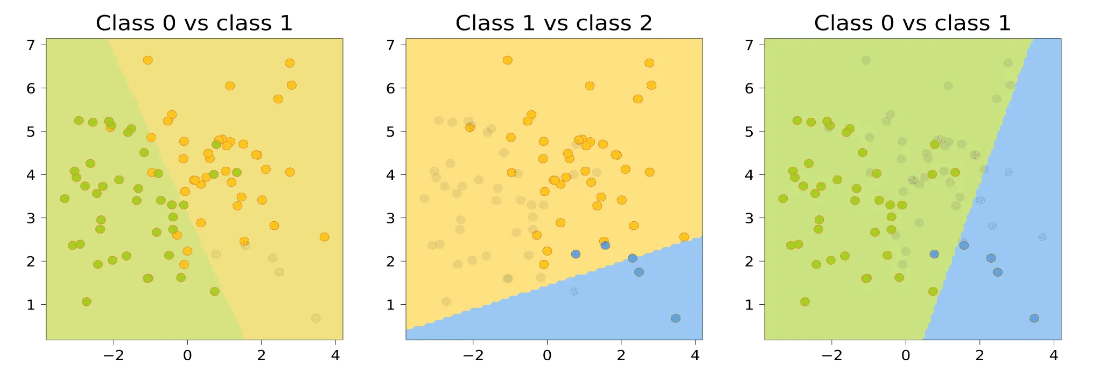

#### One vs Rest


Find 𝐾 − 1 classifiers 𝑓 , 𝑓 , ... , 𝑓 12 𝐾−1  
- 𝑓 classifies1𝑣𝑠{2,3,...,𝐾} 1
- 𝑓 classifies2𝑣𝑠{1,3,...,𝐾} 2
- ...
- 𝑓 classifies𝐾−1𝑣𝑠{1,2,...,𝐾−2}
- 𝐾−1
- Points not classified to classes {1,2, ... , 𝐾 − 1} are put to class 𝐾


#### One vs One (Cross-entropy)


В случае с бинарной (классы 0 и 1) классификацией функция потерь:

$\sum_{i=1}^l \bigl( y_i \log a_i - (1-y_i) \log (1-a_i) \bigr)  \rightarrow min$ 

$a_i$ – ответ (вероятность) алгоритма на i-м объекте на вопрос принадлежности к классу $y_i$

Обобщается для многомерного случая:
$$-\frac{1}{q} \sum_{i=1}^q \sum_{j=1}^l y_{ij} \log a_{ij} \rightarrow min $$
где  
$q$ – число элементов в выборке,  
$l$ – число классов,   
$a_{ij}$ – ответ (вероятность) алгоритма на i-м объекте на вопрос принадлежности его к j-му классу

__Проблемы:__

- Сложности в поиске глобального минимума, так как присутствуют Локальные минимумы и плато

<a id="2.2"></a>
## 2.2. Solvers

![picture](data/solvers.png)

Source: [User Guide](https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression)

### Напоминание

1. **L1-регуляризация (Lasso)**:
L1-регуляризация добавляет штраф за сумму абсолютных значений коэффициентов к функции потерь. Формула выглядит следующим образом

$$
L_{\text{L1}} = \lambda \sum_{j=1}^{n} |w_j|
$$.

2. **L2-регуляризация (Ridge)**:
L2-регуляризация добавляет штраф за сумму квадратов коэффициентов к функции потерь. Формула выглядит следующим образом

$$
L_{\text{L2}} = \lambda \sum_{j=1}^{n} w_j^2
$$

3. **ElasticNet-регуляризация**:
ElasticNet объединяет L1 и L2 регуляризации, добавляя оба штрафа к функции потерь. Формула для ElasticNet выглядит следующим образом

$$
L_{\text{ElasticNet}} = \alpha L_{\text{L1}} + (1 - \alpha) L_{\text{L2}}
$$

### Liblinear
Используется обычный покоординантный спуск.
Алгоритм:
- Инициализацируем любыми значениями вектор весов
- Повторяем для каждого i из пространства признаков:
    - фиксируем все веса, кроме w₁. Находим значение w₁, которое минимизирует функцию потерь (часто это можно сделать аналитически).
    - фиксируем все веса, включая новое w₁, кроме w₂. Находим оптимальное w₂.
    - продолжаем для всех весов w₃, ..., wₙ.
Цикл по всем координатам повторяется до сходимости.

Как это выглядит для минимизации функционала

![picture](data/liblinear.png)

__Недостатки:__
1. Не параллелится
2. Может "застрять" в локальном минимуме
3. Следствие п.2 - Не может использоваться кросс-энтропия для многомерного случая, так как легко "Застревает" в локальных минимумах. Вместо этого для каждого класса строит отдельный классификатор (One-vs-Rest)

In [43]:
%%time
lr = LogisticRegression(solver='liblinear', multi_class='ovr')
lr.fit(x_train, y_train)

CPU times: user 306 ms, sys: 13.6 ms, total: 320 ms
Wall time: 135 ms


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'liblinear'
,max_iter,100
,multi_class,'ovr'


In [44]:
accuracy_score(lr.predict(x_test), y_test)

0.9611111111111111

In [174]:
%%time
len_c = 10
param_grid={
    'C': np.linspace(0.01, 1, len_c),
    'penalty': ['l1', 'l2']
    }

gs=GridSearchCV(lr,param_grid=param_grid, cv=3,
                n_jobs=-1, scoring='accuracy')
gs.fit(x_train, y_train)

CPU times: user 166 ms, sys: 123 ms, total: 289 ms
Wall time: 4.97 s


,estimator,LogisticRegre...(solver='sag')
,param_grid,"{'C': array([0.01, ..., 0.89, 1. ]), 'penalty': ['l1', 'l2']}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,penalty,'l2'


In [46]:
accuracy_score(gs.predict(x_test), y_test)

0.9638888888888889

In [47]:
def print_cv_results(a, len_gs, params, param_r, param_sep):
    d = len(params['param_grid'][param_sep])
    ar=np.array(a).reshape(d, len_gs).T

    df=pd.DataFrame(ar)

    pen_par=params['param_grid'][param_sep]
    c_par=params['param_grid'][param_r].tolist()
    columns_mapper=dict(zip(range(0, len(pen_par)),pen_par))
    row_mapper=dict(zip(range(0, len(c_par)), c_par))

    df.rename(columns=columns_mapper, index=row_mapper, inplace=True)

    plot = df.plot(title='Mean accuracy rating',grid=True)
    plot.set_xlabel(param_r, fontsize=13)
    plot.set_ylabel('acc', rotation=0, fontsize=13, labelpad=15)

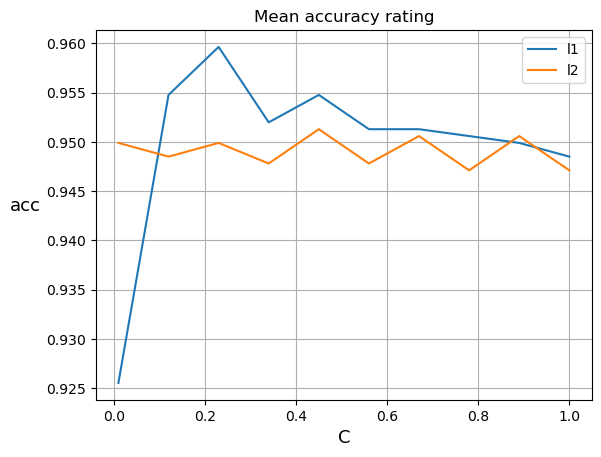

In [48]:
print_cv_results(gs.cv_results_['mean_test_score'],
                 len_c, gs.get_params(), 'C','penalty')

### Newton-cg (Newton’s Method)

Геометрическая интерпретация метода Ньютона заключается в том, что на каждой итерации приближается f(x) квадратичной функцией, а затем делает шаг к максимуму / минимуму этой квадратичной функции.

Недостатки:

1. Затратно с точки зрения вычислений матрицы Гессе (т.е. вычислений вторых частных производных).

2. Может остановиться в седловой точке, которые часто появляются при многопараметрической оптимизации.

In [49]:
%%time
lr = LogisticRegression(solver='newton-cg', penalty='l2')
lr.fit(x_train, y_train)

CPU times: user 32.9 s, sys: 989 ms, total: 33.9 s
Wall time: 8.67 s


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'newton-cg'
,max_iter,100
,multi_class,'deprecated'


In [50]:
accuracy_score(lr.predict(x_test), y_test)

0.975

In [51]:
%%time
len_c = 10
param_grid={
    'C': np.linspace(0.01, 1, len_c),
    'multi_class': ['ovr', 'multinomial']
    }

gs=GridSearchCV(lr,param_grid=param_grid, cv=3,
                n_jobs=-1, scoring='accuracy')
gs.fit(x_train, y_train)

CPU times: user 1min 45s, sys: 3.19 s, total: 1min 48s
Wall time: 28.8 s


,estimator,LogisticRegre...r='newton-cg')
,param_grid,"{'C': array([0.01, ..., 0.89, 1. ]), 'multi_class': ['ovr', 'multinomial']}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,penalty,'l2'


In [52]:
accuracy_score(gs.predict(x_test), y_test)

0.975

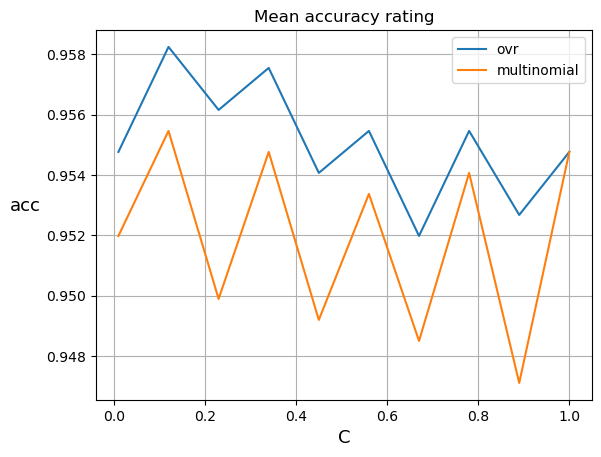

In [53]:
print_cv_results(gs.cv_results_['mean_test_score'],
                 len_c, gs.get_params(), 'C','multi_class')

### Lbfgs (Limited-memory Broyden–Fletcher–Goldfarb–Shanno Algorithm)

Аналог метода Ньютона (квазиньютоновский метод), но здесь матрица Гессе аппроксимируется с использованием оценок градиента.

Ограниченная память означает, что хранится только несколько векторов, которые неявно представляют приближение матрицы.

Solver «lbfgs» рекомендуется использовать для небольших наборов данных, так как для больших наборов данных снижается его производительность.

“lbfgs” solver используется в sklearn по умолчанию из-за его устойчивости.

In [54]:
%%time
lr = LogisticRegression(solver='lbfgs', penalty='l2')
lr.fit(x_train, y_train)

CPU times: user 24 s, sys: 720 ms, total: 24.7 s
Wall time: 6.13 s


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [55]:
accuracy_score(lr.predict(x_test), y_test)

0.9694444444444444

In [56]:
%%time
len_c = 10
param_grid={
    'C': np.linspace(0.01, 1, len_c),
    'multi_class': ['ovr', 'multinomial']
    }

gs=GridSearchCV(lr,param_grid=param_grid, cv=3,
                n_jobs=-1, scoring='accuracy')
gs.fit(x_train, y_train)

CPU times: user 20.7 s, sys: 656 ms, total: 21.4 s
Wall time: 6.37 s


,estimator,LogisticRegression()
,param_grid,"{'C': array([0.01, ..., 0.89, 1. ]), 'multi_class': ['ovr', 'multinomial']}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,penalty,'l2'


In [57]:
accuracy_score(gs.predict(x_test), y_test)

0.975

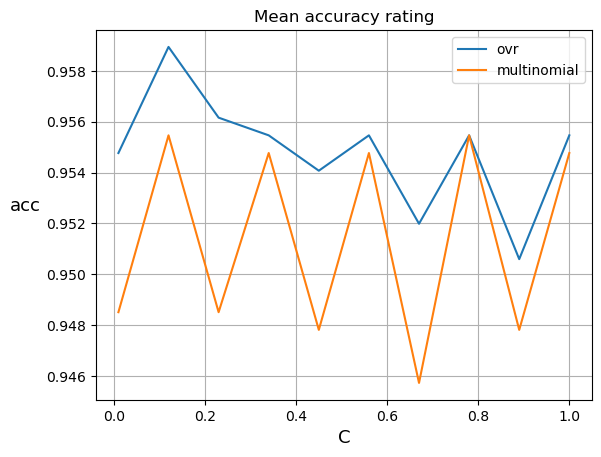

In [58]:
print_cv_results(gs.cv_results_['mean_test_score'],
                 len_c, gs.get_params(), 'C','multi_class')

### Stochatic Average Gradient (SAG)

Объединение градиентного спуска и стохастического.
При этом, он имеет низкую стоимость итерации свойственной SGD, но делает шаг градиента по отношению к аппроксимации полного градиента:


__Недостатки:__
- Нет L1
- Непрактичен для больших выборок, так как имеет высокую вычислительную сложность

In [59]:
%%time
lr = LogisticRegression(solver='sag', penalty='l2')
lr.fit(x_train, y_train)

CPU times: user 320 ms, sys: 9.79 ms, total: 329 ms
Wall time: 178 ms


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'sag'
,max_iter,100
,multi_class,'deprecated'


In [60]:
accuracy_score(lr.predict(x_test), y_test)

0.9694444444444444

In [61]:
%%time
len_c = 10
param_grid={
    'C': np.linspace(0.01, 1, len_c),
    'multi_class': ['ovr', 'multinomial']
    }

gs=GridSearchCV(lr,param_grid=param_grid, cv=3,
                n_jobs=-1, scoring='accuracy')
gs.fit(x_train, y_train)

CPU times: user 147 ms, sys: 33.7 ms, total: 181 ms
Wall time: 3.53 s


,estimator,LogisticRegre...(solver='sag')
,param_grid,"{'C': array([0.01, ..., 0.89, 1. ]), 'multi_class': ['ovr', 'multinomial']}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,penalty,'l2'


In [62]:
accuracy_score(gs.predict(x_test), y_test)

0.975

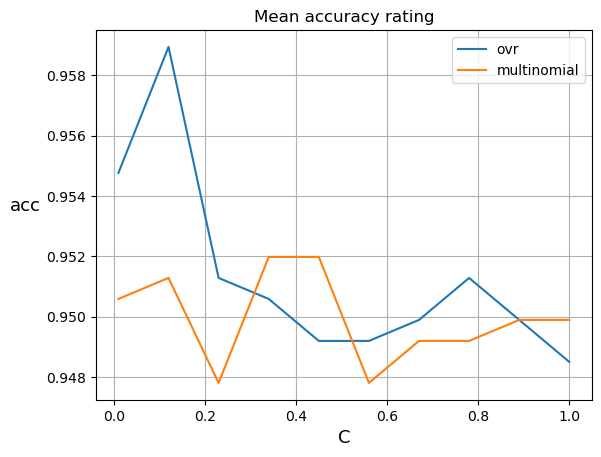

In [63]:
print_cv_results(gs.cv_results_['mean_test_score'],
                 len_c, gs.get_params(), 'C','multi_class')

### Stochatic Average Gradient Augmented (SAGA)

SAGA является вариантом SAG, но который поддерживает опцию non-smooth penalty=l1 (т. е. регуляризацию L1).

Кроме того, это единственный Solver, поддерживающий регуляризацию = "elasticnet" (l1 + l2).

[Подробнее](https://www.di.ens.fr/~fbach/Defazio_NIPS2014.pdf)

In [64]:
lr_clf = LogisticRegression(solver='saga', max_iter=1500)

In [65]:
%%time
len_c = 3
param_grid={
    'C': np.linspace(0.01, 1, len_c),
    #'multi_class': ['ovr', 'multinomial'],
    'penalty': ['l1', 'l2', "elasticnet"]
    }

gs=GridSearchCV(lr_clf,param_grid=param_grid, cv=3,
                n_jobs=-1, scoring='accuracy')
gs.fit(x_train, y_train)

CPU times: user 419 ms, sys: 42.3 ms, total: 461 ms
Wall time: 10.3 s


,estimator,LogisticRegre...solver='saga')
,param_grid,"{'C': array([0.01 , 0.505, 1. ]), 'penalty': ['l1', 'l2', ...]}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,penalty,'l2'


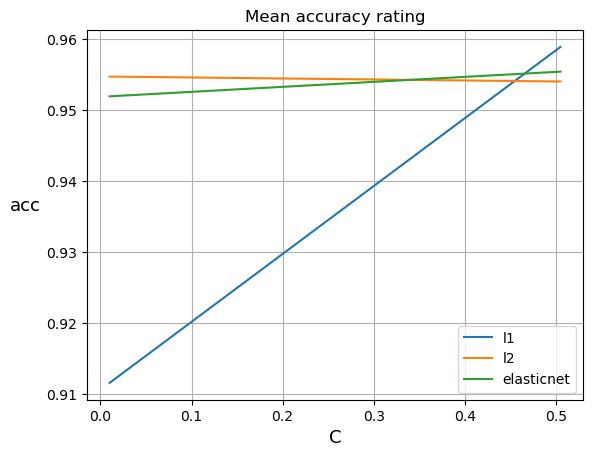

In [66]:
print_cv_results(gs.cv_results_['mean_test_score'],
                 len_c, gs.get_params(), 'C','penalty')

In [67]:
accuracy_score(gs.predict(x_test), y_test)

0.975

<a id="3"></a>
# 3. Что почитать:
- [Regularized Logistic Regression is Strictly Convex](http://www.qwone.com/~jason/writing/convexLR.pdf)
- [SAGA: A Fast Incremental Gradient Method With Support for Non-Strongly Convex Composite Objectives
](https://www.di.ens.fr/~fbach/Defazio_NIPS2014.pdf)
- [Лекции Евгения Соколова](https://github.com/esokolov/ml-course-hse/tree/master/2018-fall/lecture-notes)
- [Всё про метрики классификации и регрессии](https://education.yandex.ru/handbook/ml/article/metriki-klassifikacii-i-regressii#mnogoklassovaya-klassifikaciya)